# Transfer learning sur les images :

* Comparaison des différents modèles d'entrainement: 

# Partie : 2 

## Comparatif de modèles avec nombres reduits des images : 

* Différentes fonctions importantes pour entrainer nos modèles : 

In [65]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import keras
import keras.applications as kapps
import tensorflow as tf

#
# Paramétres par défaut
#
NB_ECHANTILLONS=15000
BATCH_SIZE = 32
NB_CLASSES = 27 
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.15
EPOCHSS = [5, 10] # [epochs en mode freezed, epochs en mode unfreezed]
OPTIMIZERS = [keras.optimizers.Adam(lr=1e-3),
             keras.optimizers.Adam(lr=1e-4)]

def read_X(nb=NB_ECHANTILLONS):
    """
    Lecture de nb entrées et ajout des colonnes 'imgpath' et 'class'
    """
    def image_path(row, subdir="image_train"):
        f = "image_%d_product_%d.jpg" % (row.imageid, row.productid) 
        ff = os.path.join(os.getcwd(), "images", subdir, f)
        return ff if os.path.isfile(ff) else None
    X = pd.read_csv("X_train_update.csv")[:nb]
    y = pd.read_csv("Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"][:nb]
    X['imgpath'] = X.apply(lambda x: image_path(x), axis=1)
    X['class'] = y.astype(str) # Needed by generator
    return X

def image_data_generator(X_train,
                         X_test,
                         img_height,
                         img_width,
                         preprocessing_function,
                         batch_size,
                         validation_split):
    """
    Générateurs d'images, elle sont augmentées pour train et validation
    Quand ils existent on utilise les preprocesseurs fournis par les modèles et
    non le paramètre rescale=1./255. Certains modèles comme EfficientNet incluent
    le preprocessing dans le modèle lui-même.
    Le générateur de test n'est pas augmenté, ni mélangé (pour garder les indices
    de classes dans l'ordre initial)
    """
    datagenerator = keras.preprocessing.image.ImageDataGenerator(
        validation_split = validation_split,
        preprocessing_function = preprocessing_function,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.1,
        brightness_range=[0.9, 1.1],
        horizontal_flip = True
    )
    traingen = datagenerator.flow_from_dataframe(
        subset = 'training', dataframe=X_train, x_col="imgpath", y_col="class",
        class_mode="sparse", target_size=(img_height, img_width), batch_size=batch_size
    )
    valgen = datagenerator.flow_from_dataframe(
        subset='validation', dataframe=X_train, x_col="imgpath", y_col="class",
        class_mode="sparse", target_size=(img_height, img_width), batch_size=batch_size
    )
    testgen = keras.preprocessing.image.ImageDataGenerator( 
        preprocessing_function = preprocessing_function).flow_from_dataframe(
        dataframe=X_test, x_col="imgpath", y_col="class",
        class_mode=None, target_size=(img_height, img_width), batch_size=batch_size,
        shuffle = False
    )

    return traingen, valgen, testgen

def plot_history(title, history):
    """
    Affiche les évolution par epoch de la perte et de l'accuracy
    """
    plt.figure(figsize=(15,3))
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title}: Loss by epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='right')
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title}: Accuracy by epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='right')
    plt.show()

def test_model(name, inputshape,pprocfunc,basemodel, topmodel,basetrainable,epochss=EPOCHSS, optimizers=OPTIMIZERS):
    """
    Evalue un modèle en fonction des paramètres, le score F1-w est affiché
    """
    time0 = time.time()
    print(f"+++ {name}: Lit les échantillons")
    X = read_X()
    X = shuffle(X)
    X_train, X_test, y_train, y_test = train_test_split(X, X['class'],
                                            test_size = TEST_SPLIT,
                                            random_state = 123)
    print(f"+++ {name}: Crée les générateurs d'images")
    traingen, valgen, testgen = image_data_generator(X_train, X_test,inputshape[0], inputshape[1],pprocfunc,BATCH_SIZE,VALIDATION_SPLIT)                                              
                                                      
    print(f"+++ {name}: Freeze des layers de base et entrainement...")
    for layer in basemodel.layers:
        layer.trainable = False
    model = keras.models.Sequential([basemodel, topmodel])
    model.compile(optimizer=optimizers[0],
              loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,
                                      restore_best_weights=True, verbose=1)
    ]
    history = model.fit(traingen, epochs=epochss[0],
                    steps_per_epoch = traingen.n//traingen.batch_size,
                    validation_data = valgen,
                    validation_steps = valgen.n//valgen.batch_size,
                    callbacks=callbacks)
    plot_history(f"{name} freezed", history)
    #
    print(f"+++ {name}: Defreeze les {basetrainable} derniers layers et entrainement...")
    if 0 < epochss[-1]:
        bestweights = f"{name}.bestweights.hdf5"
        if os.path.isfile(bestweights):
            os.remove(bestweights)
        for layer in basemodel.layers[-basetrainable:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
        model.compile(optimizer=optimizers[-1],
                    loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                          restore_best_weights=True,
                                          verbose=1),
            keras.callbacks.ModelCheckpoint(filepath=bestweights,
                                        save_weights_only=True, save_best_only=True,
                                        monitor='val_loss', mode='min')
        ]
        history = model.fit(traingen, epochs=epochss[-1],
                    steps_per_epoch = traingen.n//traingen.batch_size,
                    validation_data = valgen,
                    validation_steps = valgen.n//valgen.batch_size,
                    callbacks=callbacks)
        model.load_weights(bestweights)
        plot_history(f"{name} unfreezed", history)
    #
    print(f"+++ {name}: Prédit les classes du jeu de test...")
    softmaxout = model.predict(testgen, verbose = 1)
    labels = dict((v,k) for k,v in (traingen.class_indices).items())
    assert len(labels) == NB_CLASSES
    y_pred = [labels[i] for i in np.argmax(softmaxout, axis=1)]
    score = round(f1_score(y_test, y_pred, average = "weighted"), 4)
    duration = int(time.time()-time0)
    print(f"\n+++ {name}: Weighted F1 score = {score}  ({duration} sec)\n")

    return score


C:\Users\admin\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Différents modèles testé : 
    1- InceptionV3
    2- restnet50
    3- vgg16
    4- Xception
    5- EfficientNetV2
    6- EfficientNetB0
    7- EfficientNetB1
    8- EfficientNetB3
    
    
  Le but est de comparé les score weighted F1 loss pour trier les  modèles avce (5000 et 15000 echantillons et 32,64 batch_size)

In [66]:
#
#

topmodel_A = [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(NB_CLASSES, activation='softmax')
    ]

topmodel_B = [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(NB_CLASSES, activation='softmax')
    ]

topmodel_C = [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.BatchNormalization(trainable = True,axis=1),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(trainable = True,axis=1),
        keras.layers.Dense(NB_CLASSES,activation='softmax')
    ]

def model_inceptionv3():
    inputshape = (150, 150, 3)
    pprocfunc = tf.keras.applications.inception_v3.preprocess_input
    basemodel = kapps.inception_v3.InceptionV3(input_shape = inputshape,
                                               include_top = False,
                                               weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_B)
    return test_model("InceptionV3", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=3,
                      optimizers=[keras.optimizers.RMSprop(lr=0.0001)])

def model_restnet50():
    inputshape = (224, 224, 3)
    pprocfunc = tf.keras.applications.resnet50.preprocess_input
    basemodel = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                        weights='imagenet')
    topmodel = keras.models.Sequential(topmodel_B)
    return test_model("RestNet50", inputshape, pprocfunc,
                      basemodel, topmodel,
                      basetrainable=3)

def model_vgg16():
    inputshape = (224, 224, 3)
    pprocfunc = tf.keras.applications.vgg16.preprocess_input
    basemodel = tf.keras.applications.vgg16.VGG16(input_shape = inputshape,
                                   include_top = False,
                                   weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("VGG16", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=4)

def model_xception():
    inputshape = (240, 240, 3)
    pprocfunc = tf.keras.applications.xception.preprocess_input
    basemodel = tf.keras.applications.xception.Xception(input_shape = inputshape,
                                        include_top = False,
                                        weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("Xception", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=6)

def model_efficientnetb1():
    inputshape = (240, 240, 3) # Dépend du Bx
    pprocfunc = None # Inclus dans le modèle qui attend des données [..255]
    basemodel = tf.keras.applications.EfficientNetB1(input_shape = inputshape,
                                              include_top = False,
                                              # drop_connect_rate=0.4,
                                              weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("EfficientNetB1", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=20)


def model_efficientnetb3():
    inputshape = (300, 300, 3) # Dépend du Bx
    pprocfunc = None # Inclus dans le modèle qui attend des données [..255]
    basemodel = tf.keras.applications.EfficientNetB3(input_shape = inputshape,
                                              include_top = False,
                                              # drop_connect_rate=0.4,
                                              weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("EfficientNetB3", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=20)





def model_efficientnetv2():
    inputshape = (240, 240, 3) # Dépend du Bx
    pprocfunc = None # Inclus dans le modèle qui attend des données [..255]
    basemodel = tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape = inputshape,
                                              include_top = False,
                                              # drop_connect_rate=0.4,
                                              weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("EfficientNetV2", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=20)

def model_efficientnetb0():
    inputshape = (240, 240, 3) # Dépend du Bx
    pprocfunc = None # Inclus dans le modèle qui attend des données [..255]
    basemodel = tf.keras.applications.efficientnet.EfficientNetB0(input_shape = inputshape,
                                              include_top = False,
                                              # drop_connect_rate=0.4,
                                              weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("EfficientNetB0", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=20)


def model_efficientnetb5():
    inputshape = (456, 456, 3) # Dépend du Bx
    pprocfunc = None # Inclus dans le modèle qui attend des données [..255]
    basemodel = tf.keras.applications.efficientnet.EfficientNetB5(input_shape = inputshape,
                                              include_top = False,
                                              # drop_connect_rate=0.4,
                                              weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("EfficientNetB3", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=20)






C:\Users\admin\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


+++ InceptionV3: Lit les échantillons
+++ InceptionV3: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ InceptionV3: Freeze des layers de base et entrainement...
Epoch 1/5
53/53 [==============================] - 94s 2s/step - loss: 3.0765 - accuracy: 0.1694 - val_loss: 2.5740 - val_accuracy: 0.2986
Epoch 2/5
53/53 [==============================] - 87s 2s/step - loss: 2.5974 - accuracy: 0.2800 - val_loss: 2.4270 - val_accuracy: 0.3194
Epoch 3/5
53/53 [==============================] - 88s 2s/step - loss: 2.3676 - accuracy: 0.3255 - val_loss: 2.3172 - val_accuracy: 0.3576
Epoch 4/5
53/53 [==============================] - 88s 2s/step - loss: 2.2085 - accuracy: 0.3642 - val_loss: 2.2825 - val_accuracy: 0.3368
Epoch 5/5
53/53 [==============================] - 90s 2s/step - loss: 2.1195 - accuracy: 0.3807 - val_loss: 2.2570 - val_accuracy: 0.35

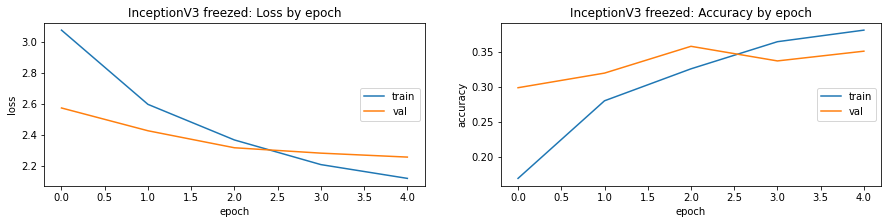

+++ InceptionV3: Defreeze les 3 derniers layers et entrainement...
Epoch 1/10
53/53 [==============================] - 97s 2s/step - loss: 1.9864 - accuracy: 0.4281 - val_loss: 2.1966 - val_accuracy: 0.3663
Epoch 2/10
53/53 [==============================] - 89s 2s/step - loss: 1.9320 - accuracy: 0.4257 - val_loss: 2.2019 - val_accuracy: 0.3698
Epoch 3/10
53/53 [==============================] - 88s 2s/step - loss: 1.8287 - accuracy: 0.4547 - val_loss: 2.2451 - val_accuracy: 0.3524
Epoch 3: early stopping


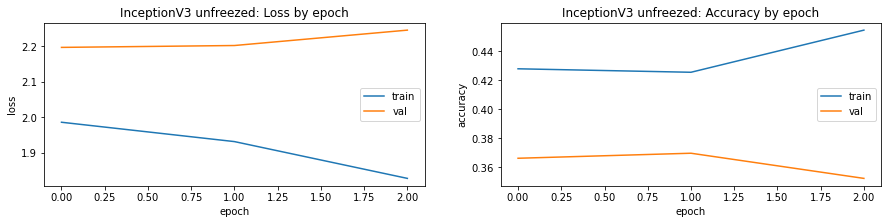

+++ InceptionV3: Prédit les classes du jeu de test...
16/16 [==============================] - 19s 1s/step

+++ InceptionV3: Weighted F1 score = 0.3263  (743 sec)



0.3263

In [9]:
model_inceptionv3()

94765736/94765736 [==============================] - 3s 0us/step
+++ RestNet50: Lit les échantillons
+++ RestNet50: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ RestNet50: Freeze des layers de base et entrainement...
Epoch 1/5
53/53 [==============================] - 369s 7s/step - loss: 2.5303 - accuracy: 0.2995 - val_loss: 1.9846 - val_accuracy: 0.4444
Epoch 2/5
53/53 [==============================] - 378s 7s/step - loss: 1.8300 - accuracy: 0.4610 - val_loss: 2.0162 - val_accuracy: 0.4132
Epoch 2: early stopping


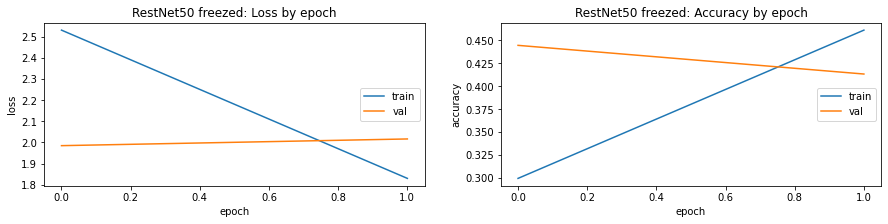

+++ RestNet50: Defreeze les 3 derniers layers et entrainement...
Epoch 1/10
53/53 [==============================] - 361s 7s/step - loss: 1.7838 - accuracy: 0.4682 - val_loss: 1.8786 - val_accuracy: 0.4531
Epoch 2/10
53/53 [==============================] - 355s 7s/step - loss: 1.6426 - accuracy: 0.5114 - val_loss: 1.8298 - val_accuracy: 0.4514
Epoch 3/10
53/53 [==============================] - 358s 7s/step - loss: 1.5541 - accuracy: 0.5372 - val_loss: 1.8103 - val_accuracy: 0.4635
Epoch 4/10
53/53 [==============================] - 355s 7s/step - loss: 1.4943 - accuracy: 0.5459 - val_loss: 1.8120 - val_accuracy: 0.4774
Epoch 5/10
53/53 [==============================] - 363s 7s/step - loss: 1.4150 - accuracy: 0.5689 - val_loss: 1.8094 - val_accuracy: 0.4688
Epoch 6/10
53/53 [==============================] - 364s 7s/step - loss: 1.3317 - accuracy: 0.5914 - val_loss: 1.7199 - val_accuracy: 0.4878
Epoch 7/10
53/53 [==============================] - 371s 7s/step - loss: 1.2587 - accurac

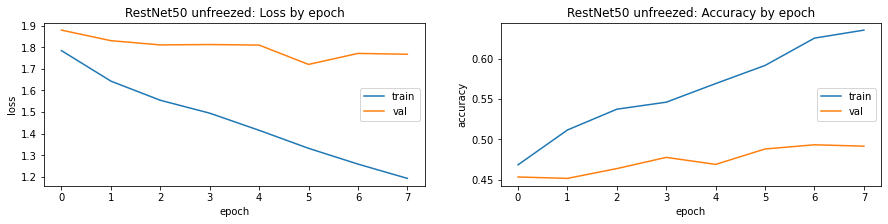

+++ RestNet50: Prédit les classes du jeu de test...
16/16 [==============================] - 93s 6s/step

+++ RestNet50: Weighted F1 score = 0.4716  (3760 sec)



0.4716

In [14]:
model_restnet50()

+++ VGG16: Lit les échantillons
+++ VGG16: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ VGG16: Freeze des layers de base et entrainement...
Epoch 1/5
53/53 [==============================] - 722s 14s/step - loss: 2.7258 - accuracy: 0.3225 - val_loss: 3.5525 - val_accuracy: 0.3368
Epoch 2/5
53/53 [==============================] - 702s 13s/step - loss: 1.7666 - accuracy: 0.4772 - val_loss: 2.3005 - val_accuracy: 0.4115
Epoch 3/5
53/53 [==============================] - 717s 14s/step - loss: 1.4747 - accuracy: 0.5552 - val_loss: 2.1722 - val_accuracy: 0.4774
Epoch 4/5
53/53 [==============================] - 740s 14s/step - loss: 1.3067 - accuracy: 0.6028 - val_loss: 1.9902 - val_accuracy: 0.4653
Epoch 5/5
53/53 [==============================] - 761s 14s/step - loss: 1.1064 - accuracy: 0.6520 - val_loss: 1.9744 - val_accuracy: 0.4896


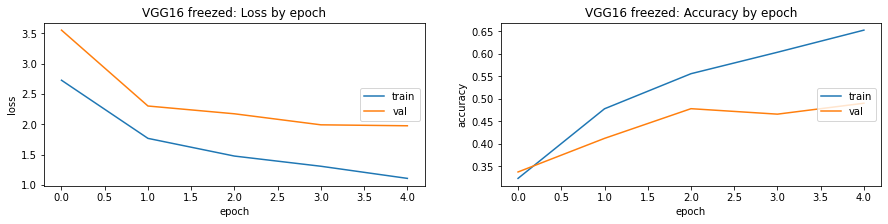

+++ VGG16: Defreeze les 4 derniers layers et entrainement...
Epoch 1/10
53/53 [==============================] - 884s 17s/step - loss: 2.4693 - accuracy: 0.3234 - val_loss: 11.0366 - val_accuracy: 0.0729
Epoch 2/10
53/53 [==============================] - 906s 17s/step - loss: 2.4195 - accuracy: 0.2989 - val_loss: 5.8334 - val_accuracy: 0.1250
Epoch 3/10
53/53 [==============================] - 886s 17s/step - loss: 2.2672 - accuracy: 0.3483 - val_loss: 3.1786 - val_accuracy: 0.2326
Epoch 4/10
53/53 [==============================] - 934s 18s/step - loss: 2.1641 - accuracy: 0.3750 - val_loss: 7.0995 - val_accuracy: 0.1944
Epoch 5/10
53/53 [==============================] - 962s 18s/step - loss: 2.0624 - accuracy: 0.3981 - val_loss: 3.2875 - val_accuracy: 0.2465
Epoch 5: early stopping


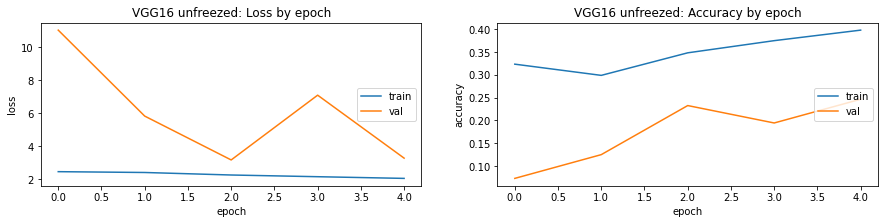

+++ VGG16: Prédit les classes du jeu de test...
16/16 [==============================] - 192s 12s/step

+++ VGG16: Weighted F1 score = 0.1457  (8441 sec)



0.1457

In [16]:
model_vgg16()

+++ Xception: Lit les échantillons
+++ Xception: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ Xception: Freeze des layers de base et entrainement...
Epoch 1/5
53/53 [==============================] - 454s 8s/step - loss: 2.7844 - accuracy: 0.3055 - val_loss: 3.3432 - val_accuracy: 0.3142
Epoch 2/5
53/53 [==============================] - 441s 8s/step - loss: 1.7689 - accuracy: 0.4787 - val_loss: 2.1537 - val_accuracy: 0.4358
Epoch 3/5
53/53 [==============================] - 396s 7s/step - loss: 1.5496 - accuracy: 0.5252 - val_loss: 2.0538 - val_accuracy: 0.4410
Epoch 4/5
53/53 [==============================] - 443s 8s/step - loss: 1.3385 - accuracy: 0.5824 - val_loss: 1.8630 - val_accuracy: 0.4583
Epoch 5/5
53/53 [==============================] - 415s 8s/step - loss: 1.2061 - accuracy: 0.6169 - val_loss: 1.9256 - val_accuracy: 0.4774
E

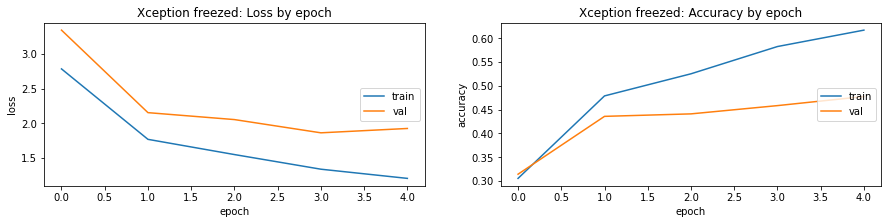

+++ Xception: Defreeze les 6 derniers layers et entrainement...
Epoch 1/10
53/53 [==============================] - 531s 10s/step - loss: 1.2803 - accuracy: 0.5986 - val_loss: 1.9058 - val_accuracy: 0.4861
Epoch 2/10
53/53 [==============================] - 511s 10s/step - loss: 0.8128 - accuracy: 0.7461 - val_loss: 1.9304 - val_accuracy: 0.4549
Epoch 3/10
53/53 [==============================] - 525s 10s/step - loss: 0.5615 - accuracy: 0.8333 - val_loss: 1.8708 - val_accuracy: 0.4965
Epoch 4/10
53/53 [==============================] - 515s 10s/step - loss: 0.4139 - accuracy: 0.8783 - val_loss: 1.8604 - val_accuracy: 0.4948
Epoch 5/10
53/53 [==============================] - 515s 10s/step - loss: 0.3228 - accuracy: 0.9086 - val_loss: 1.9033 - val_accuracy: 0.5000
Epoch 6/10
53/53 [==============================] - 517s 10s/step - loss: 0.2557 - accuracy: 0.9290 - val_loss: 1.9982 - val_accuracy: 0.4913
Epoch 6: early stopping


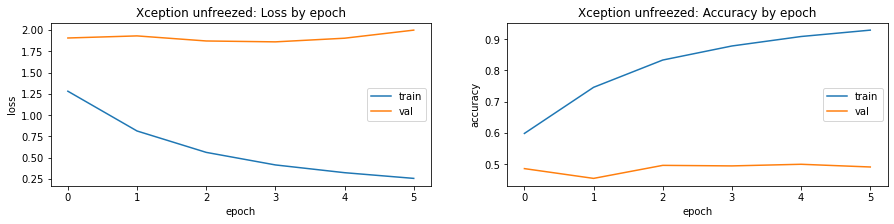

+++ Xception: Prédit les classes du jeu de test...
16/16 [==============================] - 105s 6s/step

+++ Xception: Weighted F1 score = 0.4848  (5378 sec)



0.4848

In [20]:
model_xception()

+++ EfficientNetV2: Lit les échantillons
+++ EfficientNetV2: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ EfficientNetV2: Freeze des layers de base et entrainement...
Epoch 1/5
106/106 [==============================] - 1602s 15s/step - loss: 2.6477 - accuracy: 0.3216 - val_loss: 2.2562 - val_accuracy: 0.4184
Epoch 2/5
106/106 [==============================] - 1520s 14s/step - loss: 1.9040 - accuracy: 0.4572 - val_loss: 1.9591 - val_accuracy: 0.4531
Epoch 3/5
106/106 [==============================] - 1540s 15s/step - loss: 1.6685 - accuracy: 0.5086 - val_loss: 1.9509 - val_accuracy: 0.4497
Epoch 4/5
106/106 [==============================] - 1601s 15s/step - loss: 1.5097 - accuracy: 0.5520 - val_loss: 1.8706 - val_accuracy: 0.4965
Epoch 5/5
106/106 [==============================] - 1545s 15s/step - loss: 1.3619 - accuracy: 0.5736 - val

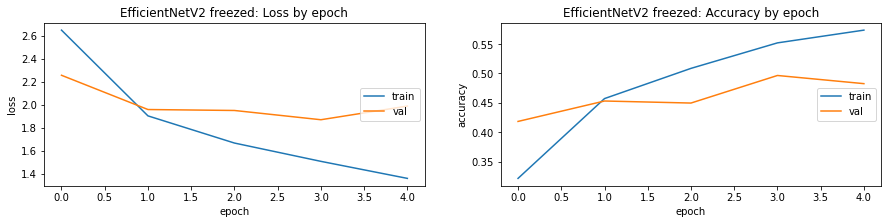

+++ EfficientNetV2: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
106/106 [==============================] - 1722s 16s/step - loss: 1.1589 - accuracy: 0.6345 - val_loss: 1.8210 - val_accuracy: 0.5087
Epoch 2/10
106/106 [==============================] - 1677s 16s/step - loss: 1.0205 - accuracy: 0.6817 - val_loss: 1.7615 - val_accuracy: 0.5382
Epoch 3/10
106/106 [==============================] - 1669s 16s/step - loss: 0.8444 - accuracy: 0.7381 - val_loss: 1.8361 - val_accuracy: 0.5156
Epoch 4/10
106/106 [==============================] - 1649s 16s/step - loss: 0.7669 - accuracy: 0.7589 - val_loss: 1.7788 - val_accuracy: 0.5243
Epoch 4: early stopping


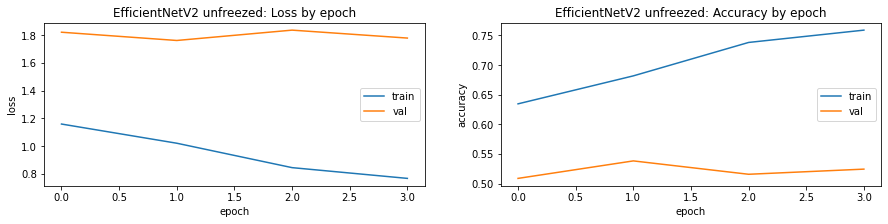

+++ EfficientNetV2: Prédit les classes du jeu de test...
32/32 [==============================] - 414s 13s/step

+++ EfficientNetV2: Weighted F1 score = 0.4933  (14954 sec)



0.4933

In [27]:
model_efficientnetv2()

+++ EfficientNetB0: Lit les échantillons
+++ EfficientNetB0: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ EfficientNetB0: Freeze des layers de base et entrainement...
Epoch 1/5
106/106 [==============================] - 337s 3s/step - loss: 2.5635 - accuracy: 0.3447 - val_loss: 2.0788 - val_accuracy: 0.4323
Epoch 2/5
106/106 [==============================] - 334s 3s/step - loss: 1.6941 - accuracy: 0.5071 - val_loss: 1.9786 - val_accuracy: 0.4601
Epoch 3/5
106/106 [==============================] - 294s 3s/step - loss: 1.3706 - accuracy: 0.5831 - val_loss: 1.9608 - val_accuracy: 0.4913
Epoch 4/5
106/106 [==============================] - 329s 3s/step - loss: 1.1689 - accuracy: 0.6336 - val_loss: 2.0595 - val_accuracy: 0.4861
Epoch 4: early stopping


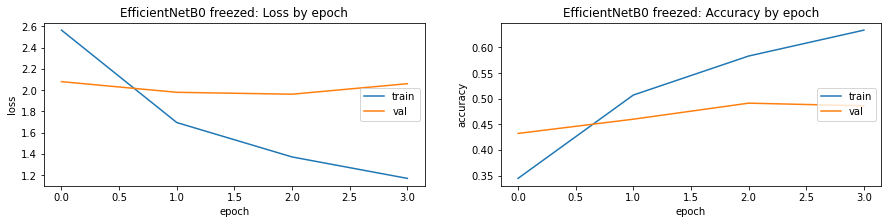

+++ EfficientNetB0: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
106/106 [==============================] - 324s 3s/step - loss: 0.9697 - accuracy: 0.7028 - val_loss: 1.8412 - val_accuracy: 0.4878
Epoch 2/10
106/106 [==============================] - 376s 4s/step - loss: 0.8142 - accuracy: 0.7438 - val_loss: 1.8492 - val_accuracy: 0.5052
Epoch 3/10
106/106 [==============================] - 340s 3s/step - loss: 0.6857 - accuracy: 0.7883 - val_loss: 1.8933 - val_accuracy: 0.5174
Epoch 3: early stopping


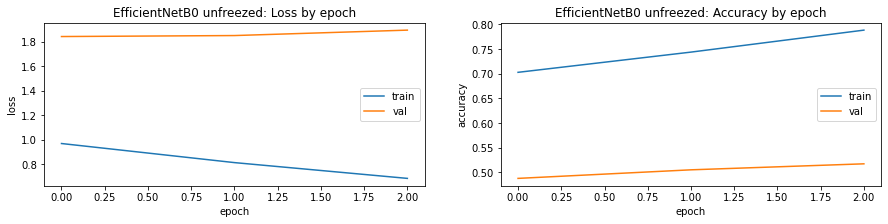

+++ EfficientNetB0: Prédit les classes du jeu de test...
32/32 [==============================] - 85s 3s/step

+++ EfficientNetB0: Weighted F1 score = 0.4927  (2496 sec)



0.4927

In [33]:
model_efficientnetb0()

+++ EfficientNetB1: Lit les échantillons
+++ EfficientNetB1: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ EfficientNetB1: Freeze des layers de base et entrainement...
Epoch 1/5
106/106 [==============================] - 406s 4s/step - loss: 2.5534 - accuracy: 0.3423 - val_loss: 2.1167 - val_accuracy: 0.4566
Epoch 2/5
106/106 [==============================] - 377s 4s/step - loss: 1.6387 - accuracy: 0.5107 - val_loss: 2.0203 - val_accuracy: 0.4601
Epoch 3/5
106/106 [==============================] - 374s 4s/step - loss: 1.3773 - accuracy: 0.5805 - val_loss: 1.9448 - val_accuracy: 0.4670
Epoch 4/5
106/106 [==============================] - 348s 3s/step - loss: 1.1746 - accuracy: 0.6315 - val_loss: 1.9867 - val_accuracy: 0.4653
Epoch 4: early stopping


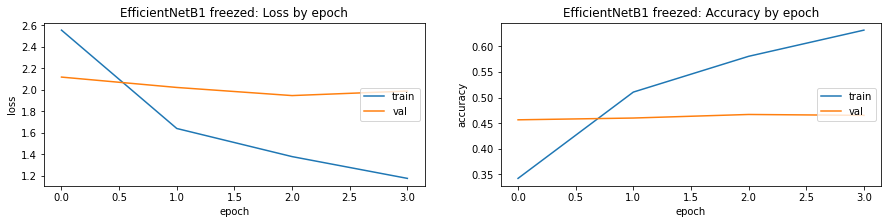

+++ EfficientNetB1: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
106/106 [==============================] - 389s 4s/step - loss: 1.0913 - accuracy: 0.6571 - val_loss: 1.8419 - val_accuracy: 0.4826
Epoch 2/10
106/106 [==============================] - 370s 3s/step - loss: 0.8249 - accuracy: 0.7488 - val_loss: 1.7767 - val_accuracy: 0.5122
Epoch 3/10
106/106 [==============================] - 382s 4s/step - loss: 0.6882 - accuracy: 0.7963 - val_loss: 1.8378 - val_accuracy: 0.5139
Epoch 4/10
106/106 [==============================] - 437s 4s/step - loss: 0.5766 - accuracy: 0.8293 - val_loss: 1.8877 - val_accuracy: 0.5035
Epoch 4: early stopping


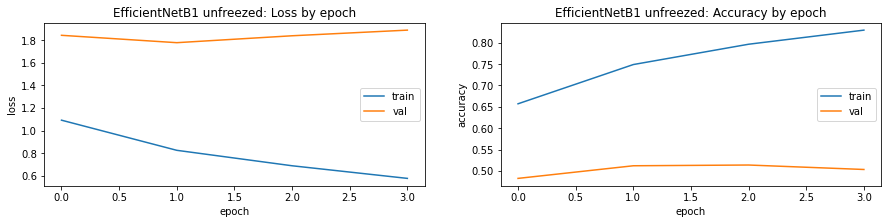

+++ EfficientNetB1: Prédit les classes du jeu de test...
32/32 [==============================] - 111s 3s/step

+++ EfficientNetB1: Weighted F1 score = 0.5082  (3201 sec)



0.5082

In [34]:
model_efficientnetb1()

+++ EfficientNetB3: Lit les échantillons
+++ EfficientNetB3: Crée les générateurs d'images
Found 3400 validated image filenames belonging to 27 classes.
Found 600 validated image filenames belonging to 27 classes.
Found 1000 validated image filenames.
+++ EfficientNetB3: Freeze des layers de base et entrainement...
Epoch 1/5
106/106 [==============================] - 855s 8s/step - loss: 2.4863 - accuracy: 0.3664 - val_loss: 1.9639 - val_accuracy: 0.4497
Epoch 2/5
106/106 [==============================] - 785s 7s/step - loss: 1.6487 - accuracy: 0.5145 - val_loss: 1.7582 - val_accuracy: 0.5017
Epoch 3/5
106/106 [==============================] - 860s 8s/step - loss: 1.3288 - accuracy: 0.6063 - val_loss: 1.8201 - val_accuracy: 0.4757
Epoch 3: early stopping


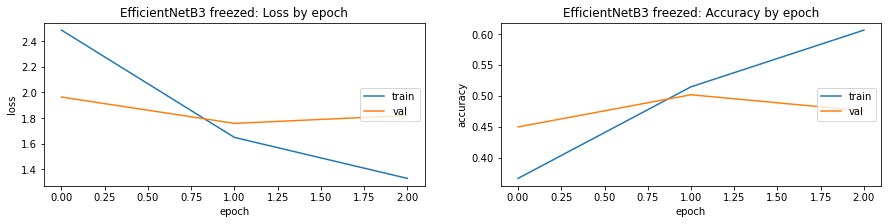

+++ EfficientNetB3: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
106/106 [==============================] - 975s 9s/step - loss: 1.1264 - accuracy: 0.6506 - val_loss: 1.6130 - val_accuracy: 0.5139
Epoch 2/10
106/106 [==============================] - 910s 9s/step - loss: 0.9133 - accuracy: 0.7173 - val_loss: 1.5776 - val_accuracy: 0.5365
Epoch 3/10
106/106 [==============================] - 905s 9s/step - loss: 0.7476 - accuracy: 0.7738 - val_loss: 1.6316 - val_accuracy: 0.5347
Epoch 4/10
106/106 [==============================] - 1016s 10s/step - loss: 0.6456 - accuracy: 0.8100 - val_loss: 1.6584 - val_accuracy: 0.5156
Epoch 4: early stopping


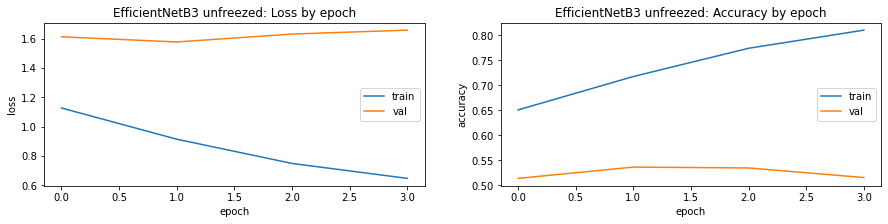

+++ EfficientNetB3: Prédit les classes du jeu de test...
32/32 [==============================] - 236s 7s/step

+++ EfficientNetB3: Weighted F1 score = 0.5055  (6593 sec)



0.5055

In [39]:
model_efficientnetb3()

In [45]:
# echantillons 15000 et batch_size = 32
NB_ECHANTILLONS=15000
BATCH_SIZE = 32
""" 1- InceptionV3   
    2- restnet50
    3- vgg16
    4- Xception
    5- EfficientNetV2
    6- EfficientNetB0
    7- EfficientNetB1
    8- EfficientNetB3
    9- EfficientNetB5"""

' 1- InceptionV3   \n    2- restnet50\n    3- vgg16\n    4- Xception\n    5- EfficientNetV2\n    6- EfficientNetB0\n    7- EfficientNetB1\n    8- EfficientNetB3\n    9- EfficientNetB5'

C:\Users\admin\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


+++ InceptionV3: Lit les échantillons
+++ InceptionV3: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ InceptionV3: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 366s 1s/step - loss: 2.6945 - accuracy: 0.2547 - val_loss: 2.1964 - val_accuracy: 0.3951
Epoch 2/5
318/318 [==============================] - 286s 899ms/step - loss: 2.2645 - accuracy: 0.3579 - val_loss: 2.0953 - val_accuracy: 0.4135
Epoch 3/5
318/318 [==============================] - 284s 891ms/step - loss: 2.0897 - accuracy: 0.3997 - val_loss: 2.0348 - val_accuracy: 0.4062
Epoch 4/5
318/318 [==============================] - 289s 907ms/step - loss: 1.9800 - accuracy: 0.4279 - val_loss: 2.0098 - val_accuracy: 0.4124
Epoch 5/5
318/318 [==============================] - 297s 933ms/step - loss: 1.8918 - accuracy: 0.4484 - val_loss

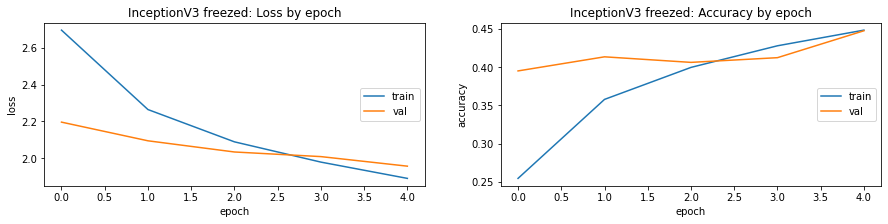

+++ InceptionV3: Defreeze les 3 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 264s 805ms/step - loss: 1.8094 - accuracy: 0.4626 - val_loss: 1.9204 - val_accuracy: 0.4436
Epoch 2/10
318/318 [==============================] - 267s 838ms/step - loss: 1.7482 - accuracy: 0.4787 - val_loss: 1.9173 - val_accuracy: 0.4498
Epoch 3/10
318/318 [==============================] - 295s 926ms/step - loss: 1.6650 - accuracy: 0.5048 - val_loss: 1.9332 - val_accuracy: 0.4492
Epoch 4/10
318/318 [==============================] - 287s 900ms/step - loss: 1.6167 - accuracy: 0.5159 - val_loss: 1.9248 - val_accuracy: 0.4487
Epoch 4: early stopping


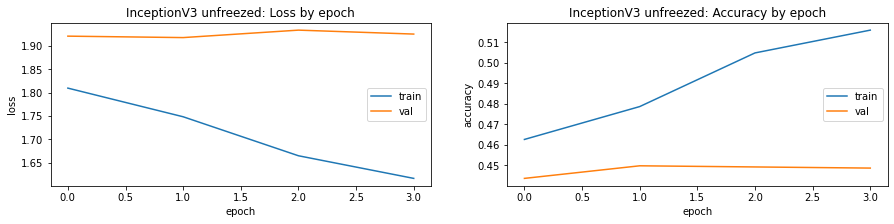

+++ InceptionV3: Prédit les classes du jeu de test...
94/94 [==============================] - 65s 664ms/step

+++ InceptionV3: Weighted F1 score = 0.4135  (2713 sec)



0.4135

In [49]:
model_inceptionv3()

+++ RestNet50: Lit les échantillons
+++ RestNet50: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ RestNet50: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 1302s 4s/step - loss: 2.1433 - accuracy: 0.3905 - val_loss: 1.7046 - val_accuracy: 0.4905
Epoch 2/5
318/318 [==============================] - 1157s 4s/step - loss: 1.7167 - accuracy: 0.4897 - val_loss: 1.6693 - val_accuracy: 0.4905
Epoch 3/5
318/318 [==============================] - 1128s 4s/step - loss: 1.5586 - accuracy: 0.5205 - val_loss: 1.5991 - val_accuracy: 0.5167
Epoch 4/5
318/318 [==============================] - 1124s 4s/step - loss: 1.4051 - accuracy: 0.5739 - val_loss: 1.5720 - val_accuracy: 0.5262
Epoch 5/5
318/318 [==============================] - 1121s 4s/step - loss: 1.3018 - accuracy: 0.5988 - val_loss: 1.6284 - va

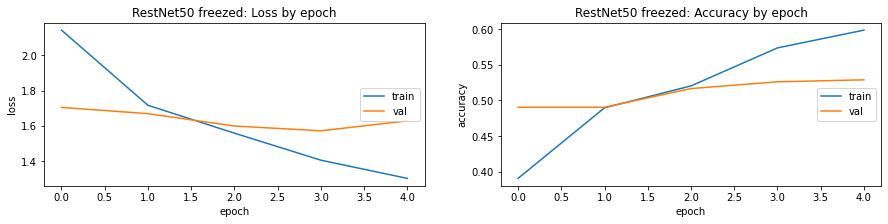

+++ RestNet50: Defreeze les 3 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 1146s 4s/step - loss: 1.1010 - accuracy: 0.6613 - val_loss: 1.4707 - val_accuracy: 0.5658
Epoch 2/10
318/318 [==============================] - 1233s 4s/step - loss: 1.0064 - accuracy: 0.6832 - val_loss: 1.4674 - val_accuracy: 0.5809
Epoch 3/10
318/318 [==============================] - 1386s 4s/step - loss: 0.9487 - accuracy: 0.6956 - val_loss: 1.4925 - val_accuracy: 0.5765
Epoch 4/10
318/318 [==============================] - 1330s 4s/step - loss: 0.9048 - accuracy: 0.7135 - val_loss: 1.4650 - val_accuracy: 0.5837
Epoch 5/10
318/318 [==============================] - 1288s 4s/step - loss: 0.8550 - accuracy: 0.7284 - val_loss: 1.5095 - val_accuracy: 0.5681
Epoch 6/10
318/318 [==============================] - 1313s 4s/step - loss: 0.8038 - accuracy: 0.7403 - val_loss: 1.5177 - val_accuracy: 0.5753
Epoch 6: early stopping


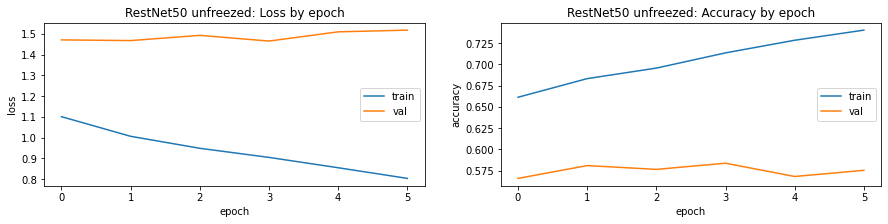

+++ RestNet50: Prédit les classes du jeu de test...
94/94 [==============================] - 273s 3s/step

+++ RestNet50: Weighted F1 score = 0.5473  (13816 sec)



0.5473

In [52]:
model_restnet50()

+++ VGG16: Lit les échantillons
+++ VGG16: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ VGG16: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 2168s 7s/step - loss: 2.3322 - accuracy: 0.3747 - val_loss: 1.9495 - val_accuracy: 0.4626
Epoch 2/5
318/318 [==============================] - 1929s 6s/step - loss: 1.7825 - accuracy: 0.4756 - val_loss: 1.7676 - val_accuracy: 0.4872
Epoch 3/5
318/318 [==============================] - 1901s 6s/step - loss: 1.6045 - accuracy: 0.5108 - val_loss: 1.7287 - val_accuracy: 0.5033
Epoch 4/5
318/318 [==============================] - 1902s 6s/step - loss: 1.5220 - accuracy: 0.5361 - val_loss: 1.6719 - val_accuracy: 0.5128
Epoch 5/5
318/318 [==============================] - 1936s 6s/step - loss: 1.4191 - accuracy: 0.5619 - val_loss: 1.6671 - val_accuracy: 

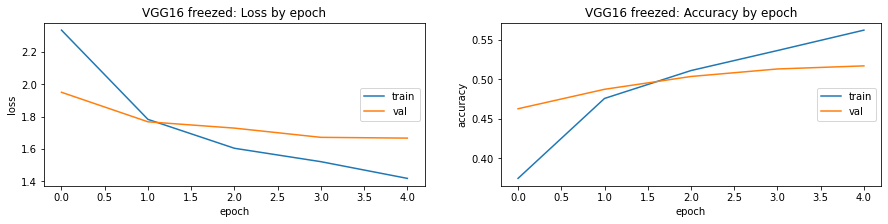

+++ VGG16: Defreeze les 4 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 2362s 7s/step - loss: 2.5321 - accuracy: 0.2667 - val_loss: 4.4813 - val_accuracy: 0.1272
Epoch 2/10
318/318 [==============================] - 2291s 7s/step - loss: 2.1981 - accuracy: 0.3501 - val_loss: 10.0603 - val_accuracy: 0.0681
Epoch 3/10
318/318 [==============================] - 2300s 7s/step - loss: 2.3961 - accuracy: 0.2943 - val_loss: 3.3649 - val_accuracy: 0.1685
Epoch 4/10
318/318 [==============================] - 2311s 7s/step - loss: 2.3199 - accuracy: 0.3215 - val_loss: 3.3593 - val_accuracy: 0.1300
Epoch 5/10
318/318 [==============================] - 2292s 7s/step - loss: 2.1503 - accuracy: 0.3644 - val_loss: 4.4676 - val_accuracy: 0.1484
Epoch 6/10
318/318 [==============================] - 2277s 7s/step - loss: 2.0496 - accuracy: 0.3931 - val_loss: 2.1643 - val_accuracy: 0.3906
Epoch 7/10
318/318 [==============================] - 2312s 7s/step - loss

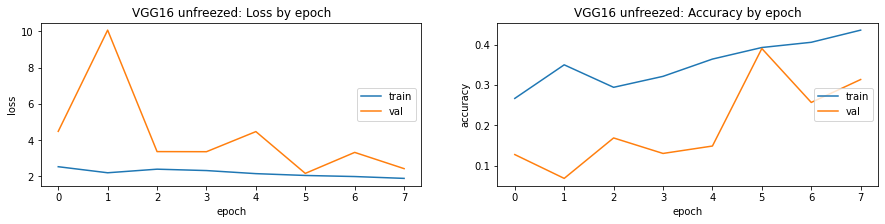

+++ VGG16: Prédit les classes du jeu de test...
94/94 [==============================] - 438s 5s/step

+++ VGG16: Weighted F1 score = 0.3541  (28672 sec)



0.3541

In [53]:
model_vgg16()

+++ Xception: Lit les échantillons
+++ Xception: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ Xception: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 1061s 3s/step - loss: 2.2762 - accuracy: 0.3878 - val_loss: 2.0086 - val_accuracy: 0.4386
Epoch 2/5
318/318 [==============================] - 1136s 4s/step - loss: 1.8093 - accuracy: 0.4679 - val_loss: 1.8136 - val_accuracy: 0.4944
Epoch 3/5
318/318 [==============================] - 1424s 4s/step - loss: 1.6443 - accuracy: 0.5100 - val_loss: 1.8273 - val_accuracy: 0.4855
Epoch 3: early stopping


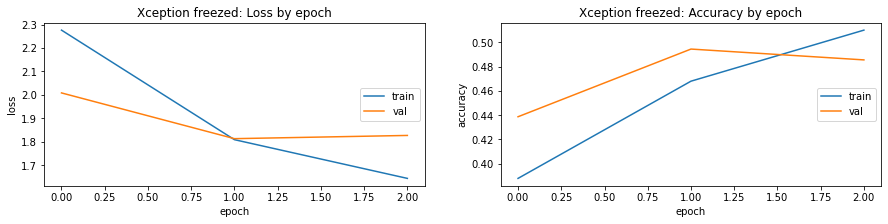

+++ Xception: Defreeze les 6 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 1173s 4s/step - loss: 1.4674 - accuracy: 0.5515 - val_loss: 1.6259 - val_accuracy: 0.5324
Epoch 2/10
318/318 [==============================] - 1194s 4s/step - loss: 1.2357 - accuracy: 0.6228 - val_loss: 1.5976 - val_accuracy: 0.5435
Epoch 3/10
318/318 [==============================] - 1194s 4s/step - loss: 1.0357 - accuracy: 0.6792 - val_loss: 1.6001 - val_accuracy: 0.5469
Epoch 4/10
318/318 [==============================] - 1334s 4s/step - loss: 0.8414 - accuracy: 0.7440 - val_loss: 1.6629 - val_accuracy: 0.5463
Epoch 4: early stopping


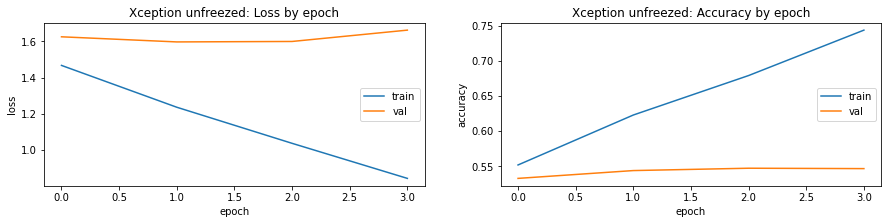

+++ Xception: Prédit les classes du jeu de test...
94/94 [==============================] - 263s 3s/step

+++ Xception: Weighted F1 score = 0.5291  (8794 sec)



0.5291

In [57]:
model_xception()

+++ EfficientNetV2: Lit les échantillons
+++ EfficientNetV2: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ EfficientNetV2: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 4018s 13s/step - loss: 2.2888 - accuracy: 0.3912 - val_loss: 1.7719 - val_accuracy: 0.4911
Epoch 2/5
318/318 [==============================] - 3968s 12s/step - loss: 1.7856 - accuracy: 0.4813 - val_loss: 1.6621 - val_accuracy: 0.5240
Epoch 3/5
318/318 [==============================] - 3985s 13s/step - loss: 1.6308 - accuracy: 0.5104 - val_loss: 1.6689 - val_accuracy: 0.5140
Epoch 3: early stopping


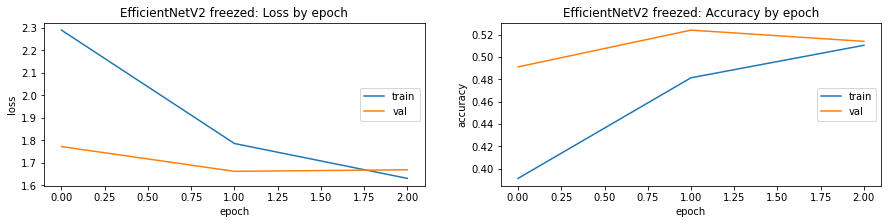

+++ EfficientNetV2: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 4675s 14s/step - loss: 1.4655 - accuracy: 0.5571 - val_loss: 1.5012 - val_accuracy: 0.5625
Epoch 2/10
318/318 [==============================] - 4328s 14s/step - loss: 1.3007 - accuracy: 0.5999 - val_loss: 1.4808 - val_accuracy: 0.5815
Epoch 3/10
318/318 [==============================] - 4332s 14s/step - loss: 1.1648 - accuracy: 0.6371 - val_loss: 1.4396 - val_accuracy: 0.5904
Epoch 4/10
318/318 [==============================] - 4541s 14s/step - loss: 1.0292 - accuracy: 0.6827 - val_loss: 1.4787 - val_accuracy: 0.5848
Epoch 5/10
318/318 [==============================] - 4534s 14s/step - loss: 0.9106 - accuracy: 0.7171 - val_loss: 1.4336 - val_accuracy: 0.6038
Epoch 6/10
318/318 [==============================] - 4244s 13s/step - loss: 0.7947 - accuracy: 0.7529 - val_loss: 1.5048 - val_accuracy: 0.5954
Epoch 7/10
318/318 [==============================] - 5179s

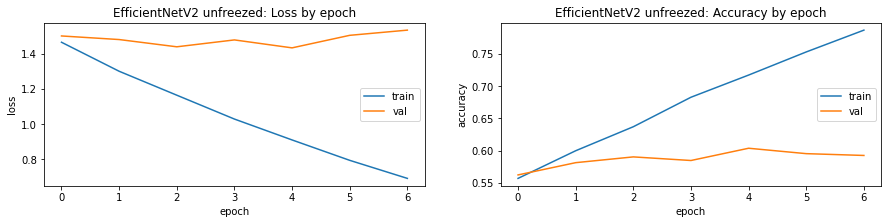

+++ EfficientNetV2: Prédit les classes du jeu de test...
94/94 [==============================] - 1091s 11s/step

+++ EfficientNetV2: Weighted F1 score = 0.5769  (44913 sec)



0.5769

In [61]:
model_efficientnetv2()

+++ EfficientNetB0: Lit les échantillons
+++ EfficientNetB0: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ EfficientNetB0: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 739s 2s/step - loss: 2.0559 - accuracy: 0.4102 - val_loss: 1.6957 - val_accuracy: 0.5028
Epoch 2/5
318/318 [==============================] - 725s 2s/step - loss: 1.5949 - accuracy: 0.5162 - val_loss: 1.6643 - val_accuracy: 0.5173
Epoch 3/5
318/318 [==============================] - 731s 2s/step - loss: 1.4640 - accuracy: 0.5502 - val_loss: 1.6077 - val_accuracy: 0.5346
Epoch 4/5
318/318 [==============================] - 722s 2s/step - loss: 1.3581 - accuracy: 0.5820 - val_loss: 1.6096 - val_accuracy: 0.5368
Epoch 4: early stopping


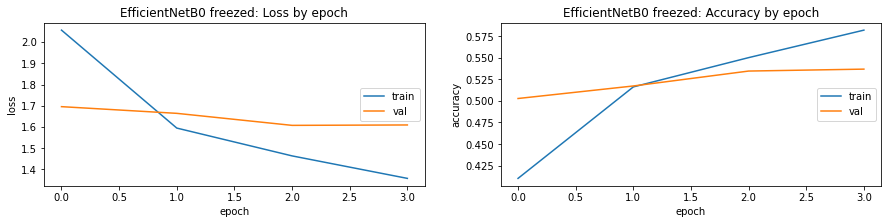

+++ EfficientNetB0: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 825s 2s/step - loss: 1.2744 - accuracy: 0.6033 - val_loss: 1.4923 - val_accuracy: 0.5658
Epoch 2/10
318/318 [==============================] - 808s 3s/step - loss: 1.0047 - accuracy: 0.6853 - val_loss: 1.4733 - val_accuracy: 0.5753
Epoch 3/10
318/318 [==============================] - 814s 3s/step - loss: 0.8600 - accuracy: 0.7306 - val_loss: 1.4858 - val_accuracy: 0.5725
Epoch 4/10
318/318 [==============================] - 804s 3s/step - loss: 0.7473 - accuracy: 0.7693 - val_loss: 1.5275 - val_accuracy: 0.5859
Epoch 4: early stopping


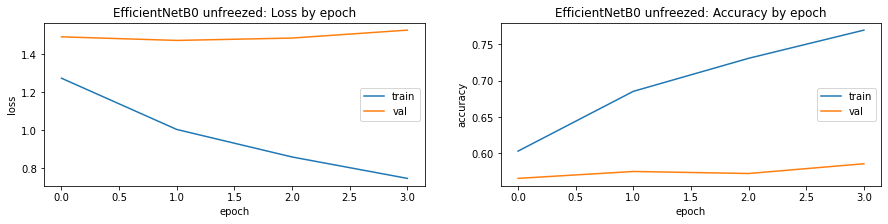

+++ EfficientNetB0: Prédit les classes du jeu de test...
94/94 [==============================] - 170s 2s/step

+++ EfficientNetB0: Weighted F1 score = 0.5818  (6352 sec)



0.5818

In [62]:
model_efficientnetb0()

+++ EfficientNetB1: Lit les échantillons
+++ EfficientNetB1: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ EfficientNetB1: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 966s 3s/step - loss: 2.0298 - accuracy: 0.4119 - val_loss: 1.6473 - val_accuracy: 0.5134
Epoch 2/5
318/318 [==============================] - 953s 3s/step - loss: 1.5979 - accuracy: 0.5197 - val_loss: 1.5826 - val_accuracy: 0.5285
Epoch 3/5
318/318 [==============================] - 968s 3s/step - loss: 1.4560 - accuracy: 0.5521 - val_loss: 1.5833 - val_accuracy: 0.5352
Epoch 3: early stopping


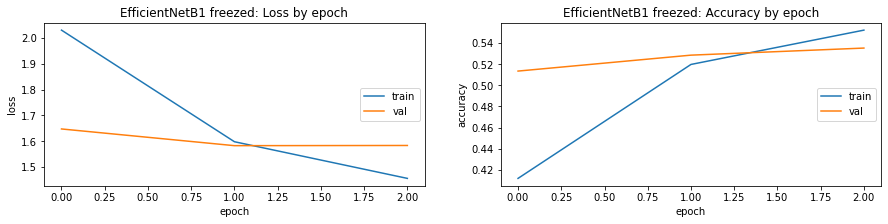

+++ EfficientNetB1: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 1155s 4s/step - loss: 1.3830 - accuracy: 0.5712 - val_loss: 1.4651 - val_accuracy: 0.5714
Epoch 2/10
318/318 [==============================] - 1124s 4s/step - loss: 1.1312 - accuracy: 0.6480 - val_loss: 1.4445 - val_accuracy: 0.5792
Epoch 3/10
318/318 [==============================] - 1262s 4s/step - loss: 0.9714 - accuracy: 0.6987 - val_loss: 1.4380 - val_accuracy: 0.5831
Epoch 4/10
318/318 [==============================] - 1348s 4s/step - loss: 0.8402 - accuracy: 0.7400 - val_loss: 1.4561 - val_accuracy: 0.5854
Epoch 5/10
318/318 [==============================] - 1313s 4s/step - loss: 0.7280 - accuracy: 0.7742 - val_loss: 1.4981 - val_accuracy: 0.5792
Epoch 5: early stopping


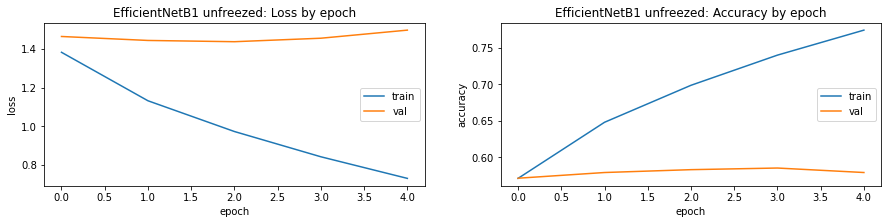

+++ EfficientNetB1: Prédit les classes du jeu de test...
94/94 [==============================] - 272s 3s/step

+++ EfficientNetB1: Weighted F1 score = 0.5731  (9374 sec)



0.5731

In [63]:
model_efficientnetb1()

+++ EfficientNetB3: Lit les échantillons
+++ EfficientNetB3: Crée les générateurs d'images
Found 10200 validated image filenames belonging to 27 classes.
Found 1800 validated image filenames belonging to 27 classes.
Found 3000 validated image filenames.
+++ EfficientNetB3: Freeze des layers de base et entrainement...
Epoch 1/5
318/318 [==============================] - 2427s 8s/step - loss: 2.2033 - accuracy: 0.4077 - val_loss: 1.6483 - val_accuracy: 0.5301
Epoch 2/5
318/318 [==============================] - 2279s 7s/step - loss: 1.6241 - accuracy: 0.5172 - val_loss: 1.6117 - val_accuracy: 0.5413
Epoch 3/5
318/318 [==============================] - 2004s 6s/step - loss: 1.4473 - accuracy: 0.5602 - val_loss: 1.4942 - val_accuracy: 0.5714
Epoch 4/5
318/318 [==============================] - 1970s 6s/step - loss: 1.3239 - accuracy: 0.5948 - val_loss: 1.5168 - val_accuracy: 0.5647
Epoch 4: early stopping


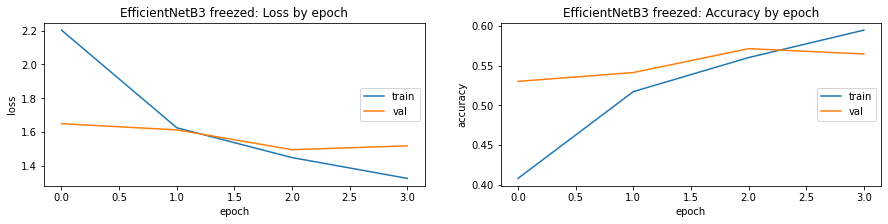

+++ EfficientNetB3: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
318/318 [==============================] - 2213s 7s/step - loss: 1.1594 - accuracy: 0.6384 - val_loss: 1.3935 - val_accuracy: 0.6077
Epoch 2/10
318/318 [==============================] - 2442s 8s/step - loss: 0.9646 - accuracy: 0.6948 - val_loss: 1.4034 - val_accuracy: 0.6060
Epoch 3/10
318/318 [==============================] - 3041s 10s/step - loss: 0.8213 - accuracy: 0.7404 - val_loss: 1.4074 - val_accuracy: 0.6155
Epoch 3: early stopping


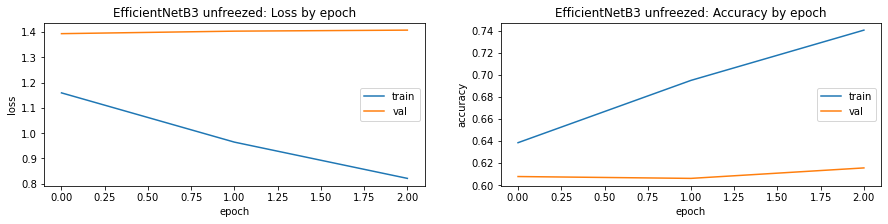

+++ EfficientNetB3: Prédit les classes du jeu de test...
94/94 [==============================] - 670s 7s/step

+++ EfficientNetB3: Weighted F1 score = 0.5716  (17065 sec)



0.5716

In [67]:
model_efficientnetb3()